### How to verify the execution of a MBQC pattern ?
Let the following circuit.

In [96]:
from graphix.random_objects import rand_circuit, Circuit
import graphix.command
import numpy as np

nqubits = 2

circuit = Circuit(nqubits)
circuit.cnot(0,1)
circuit.rz(0,np.pi/4)

pattern = circuit.transpile().pattern
pattern.standardize()

classical_output = pattern.output_nodes
print(classical_output)
# don't forget to add in the output nodes that are not initially measured!
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))

[5, 3]


In [97]:
from veriphix.client import Client, Secrets
from graphix.states import BasicStates
states = [BasicStates.PLUS for _ in pattern.input_nodes]
secrets = Secrets(r=True, a=True, theta=True)

client = Client(pattern=pattern, secrets=secrets, input_state=states)

test_runs = client.create_test_runs()
number_of_traps = sum([len(run.trap_qubits)
                    for run in test_runs])
# should be = len(client.graph[0])
n_nodes = len(client.graph[0])
print(f"The graph of the pattern has {n_nodes} nodes.")
print(f"There are {number_of_traps} traps in total. (VBQC uses single-qubit traps)")

The graph of the pattern has 6 nodes.
There are 6 traps in total.


## Concrete VBQC example

### Performing the simulation

In [98]:
import random as rd
from noise_model import VBQCNoiseModel
from graphix.sim.density_matrix import DensityMatrixBackend
from graphix.sim.statevec import StatevectorBackend
import matplotlib.pyplot as plt
import random as rd
import numpy as np
from random import randint

In [145]:
import matplotlib.pyplot as plt
import random as rd
import numpy as np
from matplotlib import cm  # Colormap
from matplotlib.colors import LogNorm


# Trappified scheme parameters
d = 1000 # nr of computation rounds
t = 1000 # nr of test rounds
N = d + t
rounds = list(range(N))
rd.shuffle(rounds)

# Re-setting the backend
backend = DensityMatrixBackend()

# Store data for each value of p
all_histograms = {}
failed_traps_histograms = {}

# Example of multiple p values (noise levels)
p_values = [0, 0.01, 0.05, 0.1, 0.5, 1]

print(f"Iterating {N} times with {d} computation rounds and {t} trap rounds.")
for p in p_values:
    noise = VBQCNoiseModel(
        entanglement_error_prob=p,
    )
    print(f"Attempt with noise model p={p}")
    outcomes_histogram = dict()

    n_failed_traps = 0
    for i in rounds:
        if i < d:
            # Computation round
            # print(f"Computation round {i}")
            client.refresh_randomness()
            client.delegate_pattern(backend=backend, noise_model=noise)
            computation_outcome = ""
            for onode in classical_output:
                computation_outcome += str(client.results[onode])
            if computation_outcome not in outcomes_histogram:
                outcomes_histogram[computation_outcome] = 1
            else:
                outcomes_histogram[computation_outcome] += 1
        else:
            # Test round
            # print(f"Test round {i}")
            run = rd.choice(test_runs)
            client.refresh_randomness()
            trap_outcomes = client.delegate_test_run(run=run, backend=backend, noise_model=noise)
            # A trap round fails if one of the single-qubit traps failed
            if sum(trap_outcomes) != 0:
                n_failed_traps += 1

    all_histograms[p] = outcomes_histogram
    failed_traps_histograms[p]=n_failed_traps/(t)

# Combine all unique outcomes from all histograms
all_outcomes = sorted(set().union(*[hist.keys() for hist in all_histograms.values()]))
print(failed_traps_histograms)


Iterating 2000 times with 1000 computation rounds and 1000 trap rounds.
Attempt with noise model p=0
Attempt with noise model p=0.01
Attempt with noise model p=0.05
Attempt with noise model p=0.1
Attempt with noise model p=0.5
Attempt with noise model p=1
{0: 0.0, 0.01: 0.039, 0.05: 0.141, 0.1: 0.254, 0.5: 0.77, 1: 0.848}


Study BQP probability

In [146]:
winning_outcome = max(all_histograms[0], key=all_histograms[0].get)
total_rounds = d
p = 1- all_histograms[0][winning_outcome]/total_rounds
print(f"p={p}")

p=0.131


### Computing the threshold
The client should reject the outcome if the proportion of traps is above the following threshold $\tau$

In [147]:
k=2
threshold = (1/k)*(2*p-1)/(2*p-2)
print(f"tau = {threshold}")

tau = 0.21231300345224396


### Plotting the histograms (matplotlib)

/var/folders/n5/hv7xz3zn675bw8ckw4q5ll3cmp3czq/T/ipykernel_45813/815169949.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



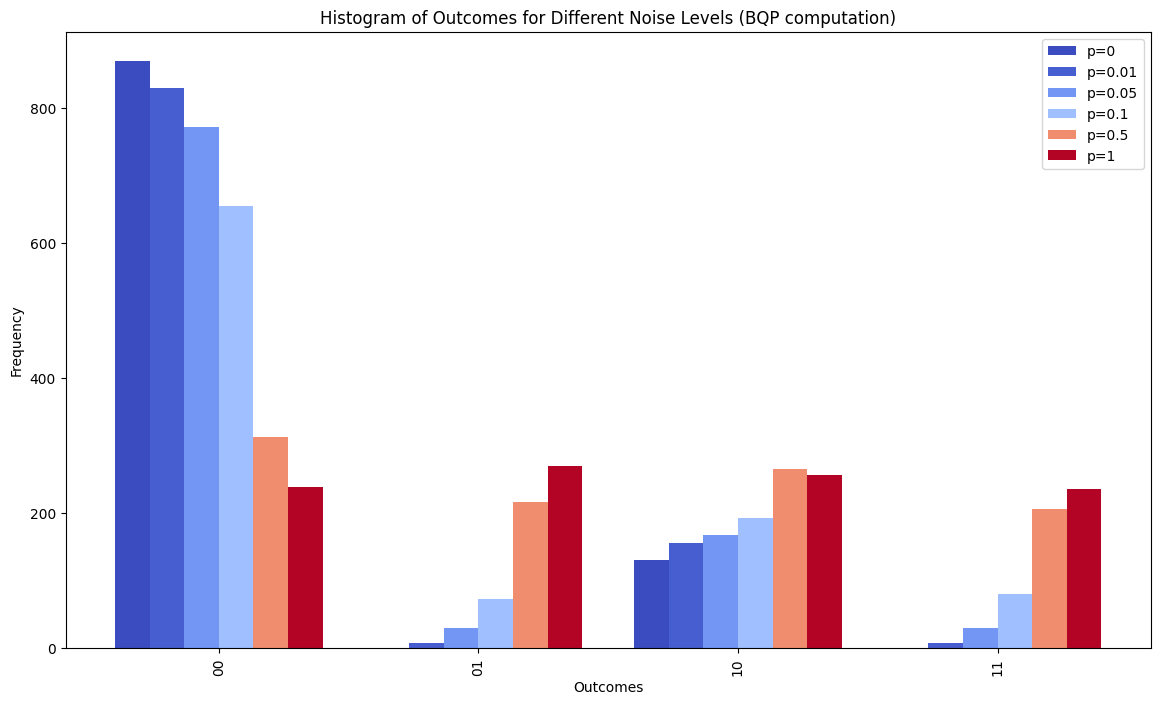

In [161]:
# Function to get color based on p value
def get_heatmap_color(p, colormap_name='coolwarm', vmin=0.1, vmax=1):
    colormap = cm.get_cmap(colormap_name)
    norm = LogNorm(vmin=vmin, vmax=vmax)  # Normalize p within [vmin, vmax]
    return colormap(norm(p))  # Get color for normalized p
# Plotting side-by-side bars with heatmap colors
x = np.arange(len(all_outcomes))  # X positions for outcomes
bar_width = 0.8 / len(p_values)  # Dynamic bar width based on the number of p values

plt.figure(figsize=(14, 8))

for idx, (p, histogram) in enumerate(all_histograms.items()):
    frequencies = [histogram.get(outcome, 0) for outcome in all_outcomes]
    color = get_heatmap_color(p+0.1)  # Get color based on p value
    plt.bar(x + idx * bar_width, frequencies, bar_width, color=color, label=f'p={p}')

plt.xlabel('Outcomes')
plt.ylabel('Frequency')
plt.title('Histogram of Outcomes for Different Noise Levels (BQP computation)')
plt.xticks(x + bar_width * (len(p_values) - 1) / 2, all_outcomes, rotation=90)
plt.legend()
plt.show()


### Plotting the results (plotly)

### Histogram for the computation rounds

In [155]:
import plotly.graph_objects as go

# Initialize the figure
fig = go.Figure()

# Store the p values in a list to access them by index in buttons
p_values = list(all_histograms.keys())

# Add histograms for different 'p' values
for p, histogram in all_histograms.items():
    frequencies = [histogram.get(outcome, 0) for outcome in all_outcomes]
    fig.add_trace(
        go.Bar(
            x=all_outcomes,
            y=frequencies,
            name=f'p={p}',  # Legend label
            visible=(p == 0)  # Only p=0 is visible by default
        )
    )

# Custom buttons to toggle visibility based on p values
buttons = []

for i, p in enumerate(p_values):
    buttons.append(
        dict(
            label=f"p={p}",
            method="update",
            args=[
                {"visible": [j == i for j in range(len(p_values))]},  # Toggle visibility
                {"title": f"Number of occurrence per output bitstring, p={p}"},  # Update title
            ],
        )
    )

# Add reset button to show all traces
buttons.append(
    dict(
        label="Show All",
        method="update",
        args=[
            {"visible": [True] * len(p_values)},
            {"title": "Number of occurrence per output bitstring for different noise levels"},
        ],
    )
)

# Add buttons to layout
fig.update_layout(
    title="Interactive Histogram of Outcomes for Different Noise Levels",
    xaxis_title="Outcomes",
    yaxis_title="Frequency",
    barmode='group',  # Bars side by side
    updatemenus=[dict(type="buttons", showactive=True, buttons=buttons)]
)

# Display the plot
fig.show()


### Do we accept these outcomes ??? Plot the portion of failed/passed traps

In [160]:
# Create a list of pie chart traces
fig = go.Figure()
colors = ['#EF553B', '#a5ff33']  # Blue for 'Value', Red for 'Remaining'

for key, value in failed_traps_histograms.items():
    fig.add_trace(go.Pie(
        labels=['Failed traps', 'Passed traps'],
        values=[value, 1 - value],
        marker=dict(colors=colors),
        name=f'Key: {key}'
    ))

# Create fixed buttons for each pie chart
fig.update_layout(
    title="Proportion of failed/accepted traps, per noise level",
    updatemenus=[
        {
            'type': 'buttons',
            'direction': 'right',
            'xanchor': 'center',
            'buttons': [
                {
                    'label': f'p= {key}',
                    'method': 'update',
                    'args': [{'visible': [i == idx for i in range(len(failed_traps_histograms))]}]
                }
                for idx, key in enumerate(failed_traps_histograms)
            ]
        }
    ]
)

# Set initial visibility (show only the first chart by default)
initial_visibility = [True] + [False] * (len(failed_traps_histograms) - 1)
fig.update_traces(visible=initial_visibility[0])

fig.show()